In [1]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm, colors
import xesmf
import cf_xarray
import scipy.stats as stats
import dask

In [2]:
from dask.distributed import Client
client = Client()
client.cluster.scale(16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33269 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33269/status,
Dashboard: /proxy/33269/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36175,Workers: 7
Dashboard: /proxy/33269/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:43123,Total threads: 1
Dashboard: /proxy/35861/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:41815,


2025-03-06 15:05:26,076 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35207'.
2025-03-06 15:18:09,473 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,477 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,484 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,492 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,498 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,504 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,510 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,520 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,524 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,583 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,585 - distributed.nanny - WARNING - Restarting worker
2025-03-06 15:18:09,589 - distributed.nanny - WARNING - R

In [3]:
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
# ENSO years
EN = [1982, 1986, 1987, 1991, 1994, 1997, 2002, 2004, 2006, 2009, 2014, 2015, 2018]

LN = [1983, 1984, 1988, 1995, 1996, 1998, 1999, 2000, 2005, 2007, 2010, 2011, 2017, 2020, 2021, 2022]

NN = [1981, 1985, 1989, 1990, 1992, 1993, 2001, 2003, 2008, 2012, 2013, 2016, 2019]

In [43]:
# # AGCD landmask
# landmask = xr.open_dataset('/g/data/w40/asp561/agcd/mask_australia_0.05deg.nc').landmask

# # AGCD data (v2 for precip) 
# file_pattern = "/g/data/zv2/agcd/v2-0-2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{}.nc"
# # Generate list of file paths for years 1960-2022
# years = range(1960, 2023)  
# paths = [file_pattern.format(year) for year in years]
# # Open dataset 
# precip = xr.open_mfdataset(paths, combine='nested', concat_dim='time', chunks={'time':12, 'lat':'auto', 'lon':'auto'}).precip

# lat_new = np.arange(-44.5, -10.0 + 0.5, 1)  # Include upper bound
# lon_new = np.arange(112.0, 156 + 0.5, 1)  # Include upper bound

# # Create an xarray dataset representing the target grid
# grid = xr.Dataset(
#     coords={
#         "lat": (["lat"], lat_new),
#         "lon": (["lon"], lon_new)
#     }
# )

# ds_bnds = precip.to_dataset().cf.add_bounds(['lat','lon'])
# sample_bnds = grid.cf.add_bounds(['lat','lon'])

# regrid = xesmf.Regridder(ds_bnds, sample_bnds, method='conservative_normed')

# precip_regrid = regrid(precip)

# precip_regrid = precip_regrid.chunk(chunks={'time':-1, 'lat':-1, 'lon':-1})

# precip_regrid.to_netcdf('AGCD_1deg_precip.nc')

# landmask_regrid = regrid(landmask)

In [5]:
precip = xr.open_dataarray('AGCD_1deg_precip.nc').sel(time=slice('1981','2022'))
landmask = xr.open_dataarray('AGCD_1deg_landmask.nc')

In [7]:
# SON anomalies
clim = precip.groupby('time.month').mean()
anom = precip - clim.sel(month=precip['time.month'])
anom_seasonal = anom.resample(time='QS-SEP').reduce(np.mean)
anom_son = anom_seasonal.where(anom_seasonal['time'].dt.month == 9, drop=True).where(landmask.data > 0.5)

In [8]:
# Anomalies in ENSO years
anom_son_EN = anom_son.sel(time=anom_son['time'].dt.year.isin(EN)) 
anom_son_LN = anom_son.sel(time=anom_son['time'].dt.year.isin(LN)) 
anom_son_NN = anom_son.sel(time=anom_son['time'].dt.year.isin(NN)) 

In [9]:
# Quantiles for anomalies
quantiles = anom_son.quantile([0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9], dim='time')

#### Test different distribution fits

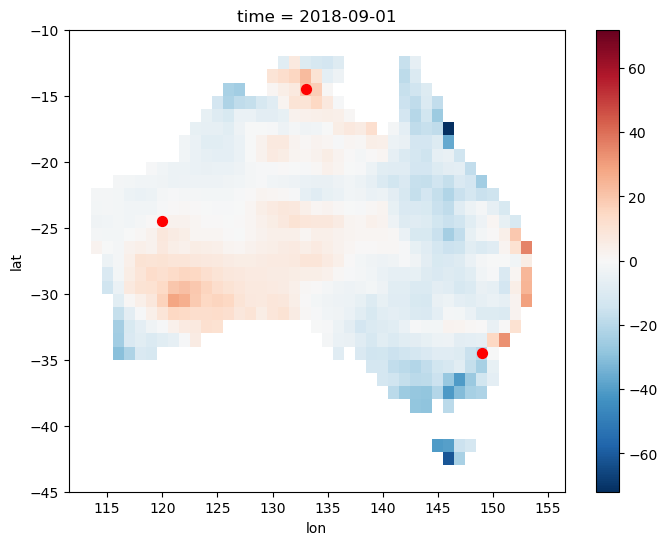

In [10]:
# Define test points (lat, lon) that may not exactly exist in the dataset
da = anom_son_EN.isel(time=-1)
target_points = [(-25, 120), (-15, 133), (-35, 149)]  # Example coordinates

# Find nearest available grid points
selected_points = [da.sel(lat=lat, lon=lon, method="nearest") for lat, lon in target_points]
nearest_lats = [point.lat.item() for point in selected_points]
nearest_lons = [point.lon.item() for point in selected_points]

# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
da.plot(ax=ax)  # Plot rainfall data

# Overlay nearest available points
ax.scatter(nearest_lons, nearest_lats, color="red", marker="o", s=50)  

In [11]:
# Calculate empirical cdf at each grid point 
def empirical_cdf(data):
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

In [12]:
def dist_test(data):
    
    distributions = [stats.norm, stats.skewnorm]
    best_fit = None
    best_ks = np.inf
    
    for dist in distributions:
        params = dist.fit(data)
        ks_stat, p_value = stats.kstest(data, dist.cdf, args=params)
        if ks_stat < best_ks:
            best_ks = ks_stat
            best_fit = dist
    
    print(f"Best fit: {best_fit.name}")
    return best_fit.name

Best fit: skewnorm
Best fit: skewnorm
Best fit: skewnorm


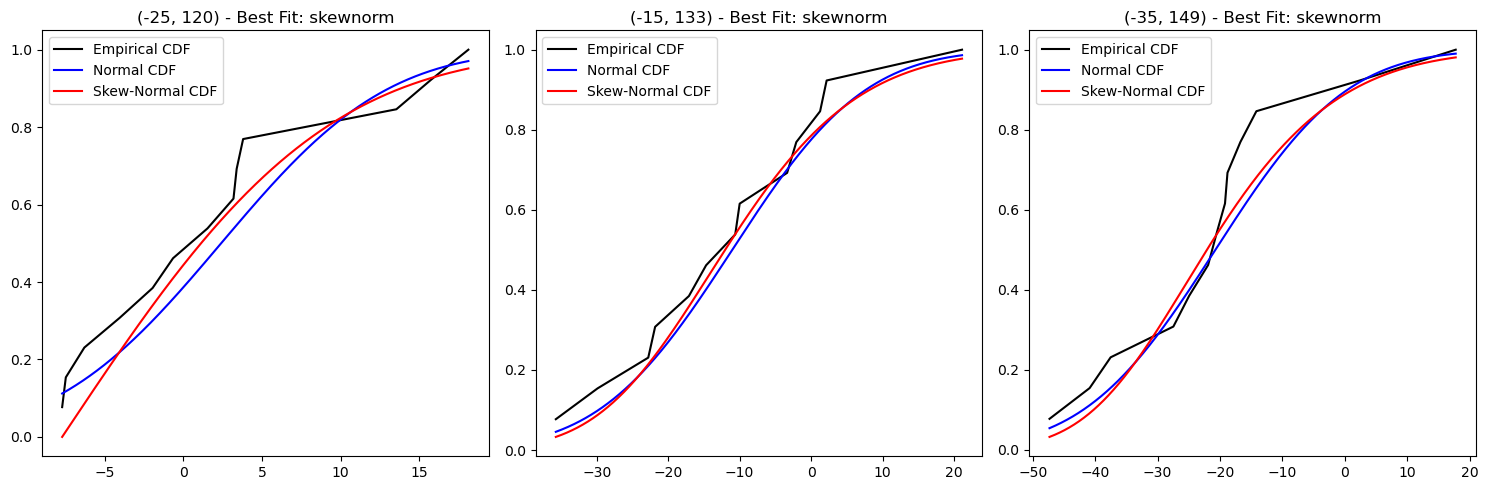

In [13]:
results = []
fig, axes = plt.subplots(1, len(target_points), figsize=(15, 5))

for i, (lat, lon) in enumerate(target_points):
    data = anom_son_EN.sel(lat=lat, lon=lon, method="nearest").values.flatten()

    # Compute empirical CDF
    data_sorted, emp_cdf = empirical_cdf(data)

    # Test distributions
    best_fit = dist_test(data)

    # Fit normal and skew-normal distributions
    x = np.linspace(min(data), max(data), 1000)
    
    mu, sigma = stats.norm.fit(data)
    norm_cdf = stats.norm.cdf(x, loc=mu, scale=sigma)
    
    alpha, loc, scale = stats.skewnorm.fit(data)
    skew_cdf = stats.skewnorm.cdf(x, alpha, loc, scale)

    # Store results
    results.append({
        "lat": lat,
        "lon": lon,
        "best_fit": best_fit,
        "mu": mu,
        "sigma": sigma,
        "alpha": alpha,
        "loc": loc,
        "scale": scale
    })

    # Plot empirical vs fitted CDFs
    ax = axes[i]
    ax.plot(data_sorted, emp_cdf, label="Empirical CDF", color="black")
    ax.plot(x, norm_cdf, label="Normal CDF", color="blue")
    ax.plot(x, skew_cdf, label="Skew-Normal CDF", color="red")
    ax.set_title(f"({lat}, {lon}) - Best Fit: {best_fit}")
    ax.legend()

plt.tight_layout()
plt.show()

Best fit: norm
Best fit: norm
Best fit: skewnorm


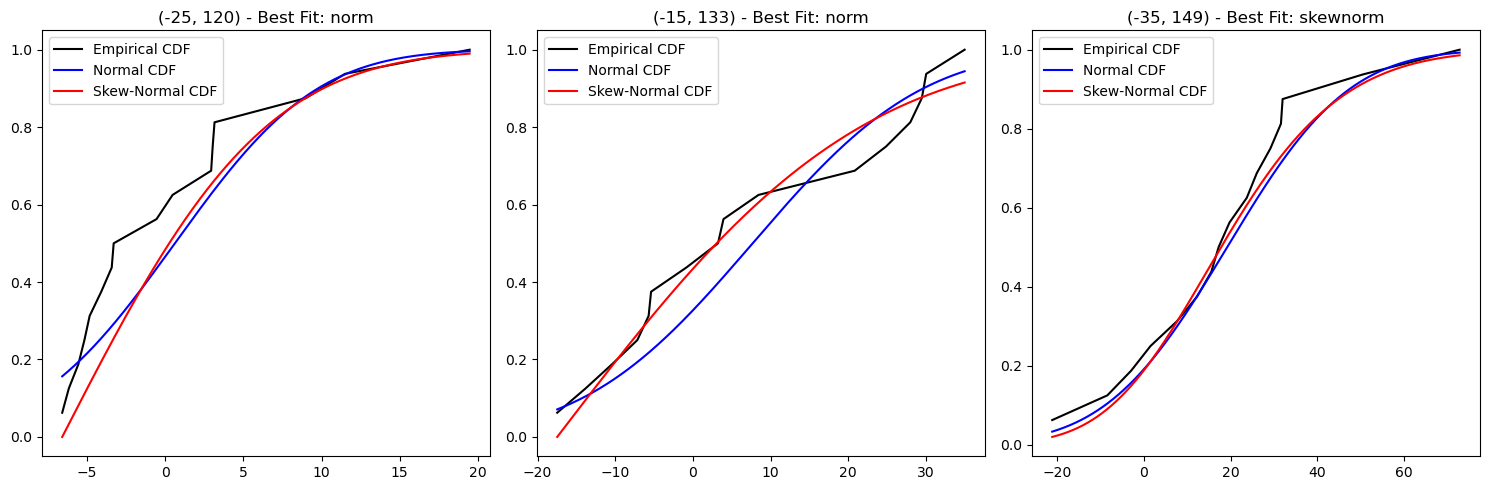

In [14]:
results = []
fig, axes = plt.subplots(1, len(target_points), figsize=(15, 5))

for i, (lat, lon) in enumerate(target_points):
    data = anom_son_LN.sel(lat=lat, lon=lon, method="nearest").values.flatten()

    # Compute empirical CDF
    data_sorted, emp_cdf = empirical_cdf(data)

    # Test distributions
    best_fit = dist_test(data)

    # Fit normal and skew-normal distributions
    x = np.linspace(min(data), max(data), 1000)
    
    mu, sigma = stats.norm.fit(data)
    norm_cdf = stats.norm.cdf(x, loc=mu, scale=sigma)
    
    alpha, loc, scale = stats.skewnorm.fit(data)
    skew_cdf = stats.skewnorm.cdf(x, alpha, loc, scale)

    # Store results
    results.append({
        "lat": lat,
        "lon": lon,
        "best_fit": best_fit,
        "mu": mu,
        "sigma": sigma,
        "alpha": alpha,
        "loc": loc,
        "scale": scale
    })

    # Plot empirical vs fitted CDFs
    ax = axes[i]
    ax.plot(data_sorted, emp_cdf, label="Empirical CDF", color="black")
    ax.plot(x, norm_cdf, label="Normal CDF", color="blue")
    ax.plot(x, skew_cdf, label="Skew-Normal CDF", color="red")
    ax.set_title(f"({lat}, {lon}) - Best Fit: {best_fit}")
    ax.legend()

plt.tight_layout()
plt.show()

Best fit: norm
Best fit: skewnorm
Best fit: skewnorm


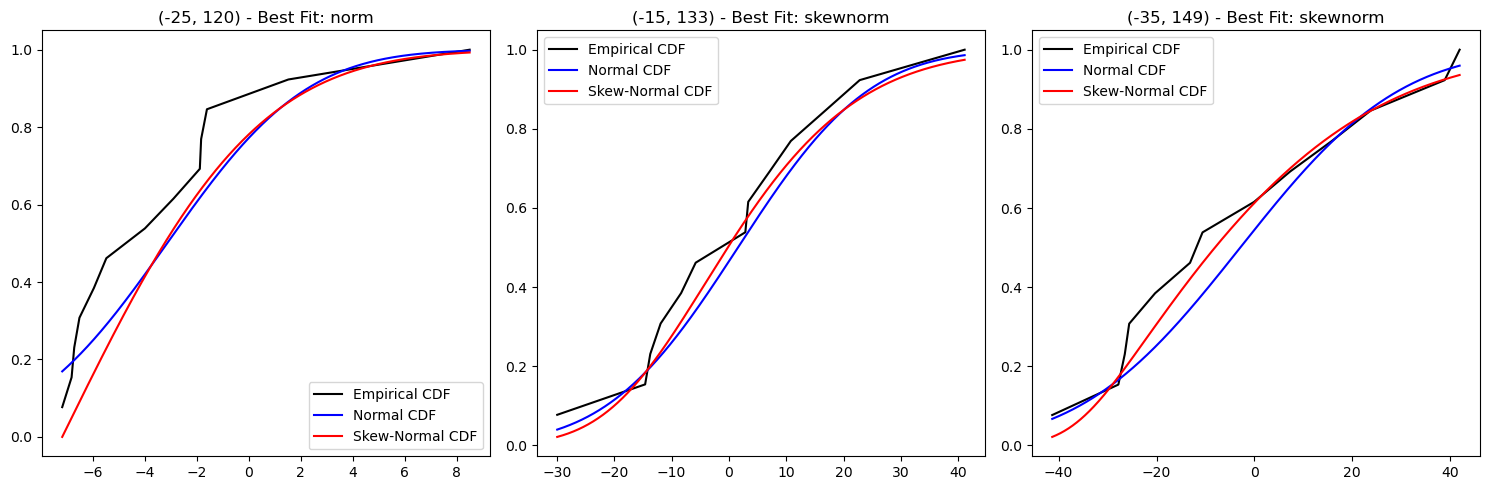

In [15]:
results = []
fig, axes = plt.subplots(1, len(target_points), figsize=(15, 5))

for i, (lat, lon) in enumerate(target_points):
    data = anom_son_NN.sel(lat=lat, lon=lon, method="nearest").values.flatten()

    # Compute empirical CDF
    data_sorted, emp_cdf = empirical_cdf(data)

    # Test distributions
    best_fit = dist_test(data)

    # Fit normal and skew-normal distributions
    x = np.linspace(min(data), max(data), 1000)
    
    mu, sigma = stats.norm.fit(data)
    norm_cdf = stats.norm.cdf(x, loc=mu, scale=sigma)
    
    alpha, loc, scale = stats.skewnorm.fit(data)
    skew_cdf = stats.skewnorm.cdf(x, alpha, loc, scale)

    # Store results
    results.append({
        "lat": lat,
        "lon": lon,
        "best_fit": best_fit,
        "mu": mu,
        "sigma": sigma,
        "alpha": alpha,
        "loc": loc,
        "scale": scale
    })

    # Plot empirical vs fitted CDFs
    ax = axes[i]
    ax.plot(data_sorted, emp_cdf, label="Empirical CDF", color="black")
    ax.plot(x, norm_cdf, label="Normal CDF", color="blue")
    ax.plot(x, skew_cdf, label="Skew-Normal CDF", color="red")
    ax.set_title(f"({lat}, {lon}) - Best Fit: {best_fit}")
    ax.legend()

plt.tight_layout()
plt.show()

#### Calculate CDFs using skewnorm

In [16]:
def fit_skewnorm_params(data):
    """Fit skew-normal distribution and return parameters."""
    data = data[~np.isnan(data)]  # Remove NaNs
    if len(np.unique(data)) < 3:
        return np.nan, np.nan, np.nan  # Not enough data to fit
    
    try:
        alpha, loc, scale = stats.skewnorm.fit(data)
        return alpha, loc, scale
    except Exception as e:
        print(f"Fit failed: {e}")
        return np.nan, np.nan, np.nan

In [18]:
alpha_EN, loc_EN, scale_EN = xr.apply_ufunc(
    fit_skewnorm_params,
    anom_son_EN,
    input_core_dims=[["time"]],
    output_core_dims=[[], [], []],  # Scalars per grid cell
    vectorize=True,
    dask="parallelized",
    output_dtypes=[anom_son_EN.dtype, anom_son_EN.dtype, anom_son_EN.dtype]
)

In [19]:
alpha_LN, loc_LN, scale_LN = xr.apply_ufunc(
    fit_skewnorm_params,
    anom_son_LN,
    input_core_dims=[["time"]],
    output_core_dims=[[], [], []],  # Scalars per grid cell
    vectorize=True,
    dask="parallelized",
    output_dtypes=[anom_son_LN.dtype, anom_son_LN.dtype, anom_son_LN.dtype]
)

In [20]:
alpha_NN, loc_NN, scale_NN = xr.apply_ufunc(
    fit_skewnorm_params,
    anom_son_NN,
    input_core_dims=[["time"]],
    output_core_dims=[[], [], []],  # Scalars per grid cell
    vectorize=True,
    dask="parallelized",
    output_dtypes=[anom_son_NN.dtype, anom_son_NN.dtype, anom_son_NN.dtype]
)

In [21]:
# alpha_EN, loc_EN, scale_EN = dask.persist(alpha_EN, loc_EN, scale_EN)

#### Calculate FAR for median, 5th, 25th, 75th, and 95th percentile
FAR = 1 - (P_N / P_A) where P_A is probability when active ENSO, and P_N is probability when neutral 

In [22]:
# Extract median rainfall values (and other quantiles) for each grid point
q10_rainfall = quantiles.sel(quantile=0.10)
q25_rainfall = quantiles.sel(quantile=0.25)
q33_rainfall = quantiles.sel(quantile=0.33)
median_rainfall = quantiles.sel(quantile=0.5)
q66_rainfall = quantiles.sel(quantile=0.66)
q75_rainfall = quantiles.sel(quantile=0.75)
q90_rainfall = quantiles.sel(quantile=0.90)

In [23]:
def get_probability_deficit_fitted(alpha, loc, scale, threshold):
    """Returns probability P(X ≥ threshold) using the fitted CDF."""
    cdf_value = stats.skewnorm.cdf(threshold, alpha, loc, scale)
    return cdf_value 
    
def get_probability_exceed_fitted(alpha, loc, scale, threshold):
    """Returns probability P(X ≥ threshold) using the fitted CDF."""
    cdf_value = stats.skewnorm.cdf(threshold, alpha, loc, scale)
    return 1 - cdf_value  # P(X ≥ threshold) = 1 - F(threshold)

def spatial_probability_deficit_fitted(alpha, loc, scale, threshold):
    """Compute spatial probability of exceedance for a given threshold."""
    P = xr.apply_ufunc(
        get_probability_deficit_fitted, alpha, loc, scale, threshold,
        input_core_dims=[[], [], [], []],  # All are scalars
        output_core_dims=[[]],  # Remove time dim
        vectorize=True,
        dask="parallelized",
        output_dtypes=[anom_son_EN.dtype]
    )
    return P

def spatial_probability_exceed_fitted(alpha, loc, scale, threshold):
    """Compute spatial probability of exceedance for a given threshold."""
    P = xr.apply_ufunc(
        get_probability_exceed_fitted, alpha, loc, scale, threshold,
        input_core_dims=[[], [], [], []],  # All are scalars
        output_core_dims=[[]],  # Remove time dim
        vectorize=True,
        dask="parallelized",
        output_dtypes=[anom_son_EN.dtype]
    )
    return P

#### Assumption that El Niño is dry based off composites - Look at rainfall probabilities below threshold 

In [24]:
P_EN_10th = spatial_probability_deficit_fitted(alpha_EN, loc_EN, scale_EN, q10_rainfall)
P_NN_10th = spatial_probability_deficit_fitted(alpha_NN, loc_NN, scale_NN, q10_rainfall)

P_EN_25th = spatial_probability_deficit_fitted(alpha_EN, loc_EN, scale_EN, q25_rainfall)
P_NN_25th = spatial_probability_deficit_fitted(alpha_NN, loc_NN, scale_NN, q25_rainfall)

P_EN_33th = spatial_probability_deficit_fitted(alpha_EN, loc_EN, scale_EN, q33_rainfall)
P_NN_33th = spatial_probability_deficit_fitted(alpha_NN, loc_NN, scale_NN, q33_rainfall)

P_EN_median_below = spatial_probability_deficit_fitted(alpha_EN, loc_EN, scale_EN, median_rainfall)
P_NN_median_below = spatial_probability_deficit_fitted(alpha_NN, loc_NN, scale_NN, median_rainfall)

#### Assumption that La Niña is wet based off composites - Look at rainfall probabilities above threshold 

In [25]:
P_LN_median_above = spatial_probability_exceed_fitted(alpha_LN, loc_LN, scale_LN, median_rainfall)
P_NN_median_above = spatial_probability_exceed_fitted(alpha_NN, loc_NN, scale_NN, median_rainfall)

P_LN_66th = spatial_probability_exceed_fitted(alpha_LN, loc_LN, scale_LN, q66_rainfall)
P_NN_66th = spatial_probability_exceed_fitted(alpha_NN, loc_NN, scale_NN, q66_rainfall)

P_LN_75th = spatial_probability_exceed_fitted(alpha_LN, loc_LN, scale_LN, q75_rainfall)
P_NN_75th = spatial_probability_exceed_fitted(alpha_NN, loc_NN, scale_NN, q75_rainfall)

P_LN_90th = spatial_probability_exceed_fitted(alpha_LN, loc_LN, scale_LN, q90_rainfall)
P_NN_90th = spatial_probability_exceed_fitted(alpha_NN, loc_NN, scale_NN, q90_rainfall)

#### Calculate FAR

In [26]:
FAR_EN_10th = 1 - (P_NN_10th / P_EN_10th)
FAR_EN_25th = 1 - (P_NN_25th / P_EN_25th)
FAR_EN_33th = 1 - (P_NN_33th / P_EN_33th)
FAR_EN_med_below = 1 - (P_NN_median_below / P_EN_median_below)

In [27]:
FAR_LN_med_above = 1 - (P_NN_median_above / P_LN_median_above)
FAR_LN_66th = 1 - (P_NN_66th / P_LN_66th)
FAR_LN_75th = 1 - (P_NN_75th / P_LN_75th)
FAR_LN_90th = 1 - (P_NN_90th / P_LN_90th)

#### La Niña plot: exceeding, median, 75th, 90th and 95th percentile

In [28]:
# FAR colorbar (discrete)
colors = [
    "#0570b0", "#3690c0", "#74a9cf", "#a6bddb", "#d0d1e6",  
    "#ffffcc", "#ffeda0", "#fed976", "#feb24c", "#fd8d3c",
    "#fc6631", "#f03b20", "#e31a1c", "#bd0026", "#e7298a"
]

bounds_prob = np.concatenate([np.linspace(-1, 0, 6), np.linspace(0.1, 1, 10)]) 
cmap_prob = mcolors.ListedColormap(colors)
norm_prob = mcolors.BoundaryNorm(bounds_prob, cmap_prob.N)

In [29]:
def format_gridlines(ax, top_labels=False, bottom_labels=False, left_labels=False, right_labels=False):
    
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.75, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = top_labels
    gl.bottom_labels = bottom_labels
    gl.right_labels = right_labels
    gl.left_labels = left_labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

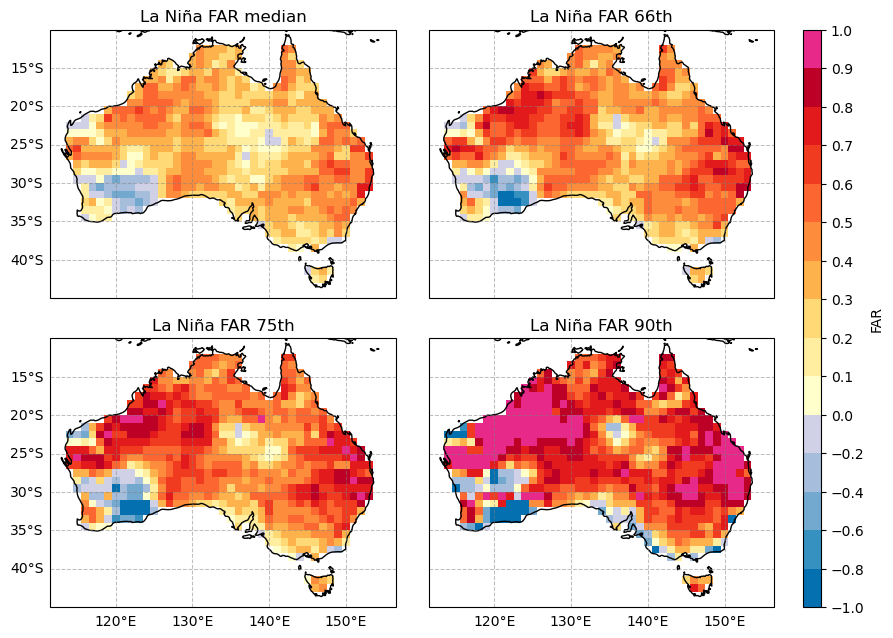

In [30]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = FAR_LN_med_above.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = FAR_LN_66th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 66th')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = FAR_LN_75th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 75th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = FAR_LN_90th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 90th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_prob)
cbar.ax.set_ylabel('FAR');

#### El Niño plot: deficit below median, 25th and 5th percentile

In [31]:
# replace zero with nan - for some reason ocean is zero
FAR_EN_med_below = FAR_EN_med_below.where(FAR_EN_med_below != 0, np.nan)
FAR_EN_33th = FAR_EN_33th.where(FAR_EN_33th != 0, np.nan)
FAR_EN_25th = FAR_EN_25th.where(FAR_EN_25th != 0, np.nan)
FAR_EN_10th = FAR_EN_10th.where(FAR_EN_10th != 0, np.nan)

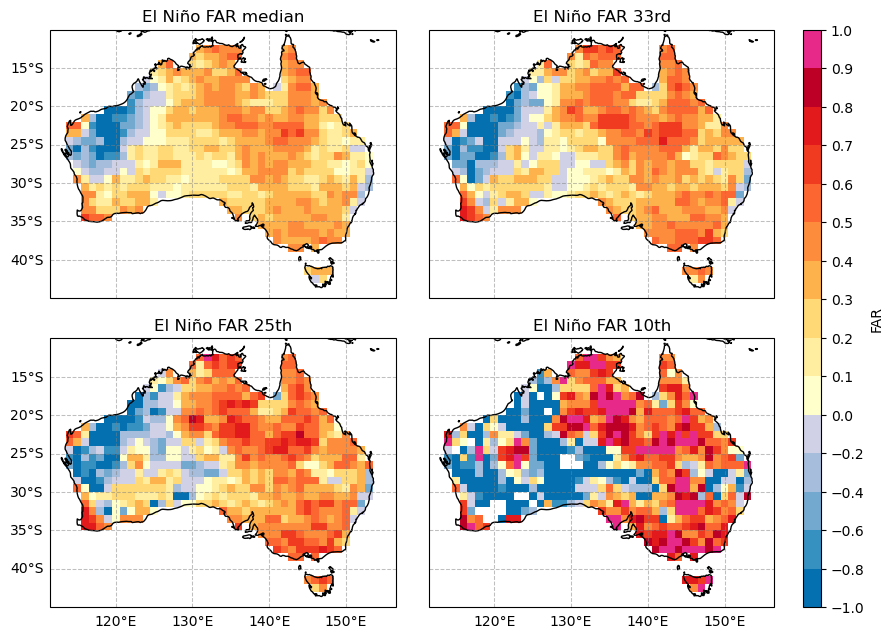

In [32]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = FAR_EN_med_below.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = FAR_EN_33th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR 33rd')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = FAR_EN_25th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR 25th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = FAR_EN_10th.plot(ax=ax, cmap=cmap_prob, norm=norm_prob, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño FAR 10th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_prob)
cbar.ax.set_ylabel('FAR');

#### Calculate RR for median, 5th, 10th 25th, 75th, 90th, and 95th percentile?

In [ ]:
# RR = PA / PN
# PA = ENSO active (EN or LN)
# PN = ENSO neutral (NN) 

In [33]:
RR_EN_10th = P_EN_10th / P_NN_10th
RR_EN_25th = P_EN_25th / P_NN_25th
RR_EN_33th = P_EN_33th / P_NN_33th
RR_EN_med_below = P_EN_median_below / P_NN_median_below

In [34]:
RR_LN_med_above = P_LN_median_above / P_NN_median_above
RR_LN_66th = P_LN_66th / P_NN_66th
RR_LN_75th = P_LN_75th / P_NN_75th
RR_LN_90th = P_LN_90th / P_NN_90th

#### La Niña plot 

In [35]:
# Risk colorbar
colors = [
    "#6baed6", "#bdd7e7",  
    "#ffffcc", "#ffeda0", "#fed976", "#feb24c", "#fd8d3c", "#f03b20", "#bd0026", "#e7298a"  
]

cmap_risk = mcolors.ListedColormap(colors)
bounds_risk = np.arange(0, 5.5, 0.5)
norm_risk = mcolors.BoundaryNorm(bounds_risk, cmap_risk.N)

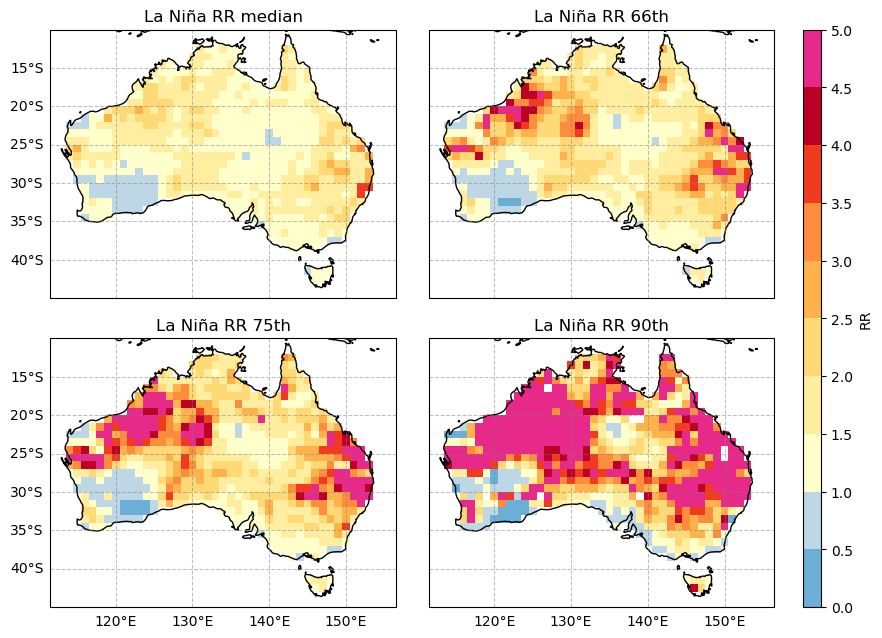

In [36]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = RR_LN_med_above.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña RR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = RR_LN_66th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña RR 66th')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = RR_LN_75th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña RR 75th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = RR_LN_90th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña RR 90th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_risk)
cbar.ax.set_ylabel('RR');

#### El Niño plot 

In [37]:
RR_EN_med_below = RR_EN_med_below.where(RR_EN_med_below != 1, np.nan)
RR_EN_33th = RR_EN_33th.where(RR_EN_33th != 1, np.nan)
RR_EN_25th = RR_EN_25th.where(RR_EN_25th != 1, np.nan)
RR_EN_10th = RR_EN_10th.where(RR_EN_10th != 1, np.nan)

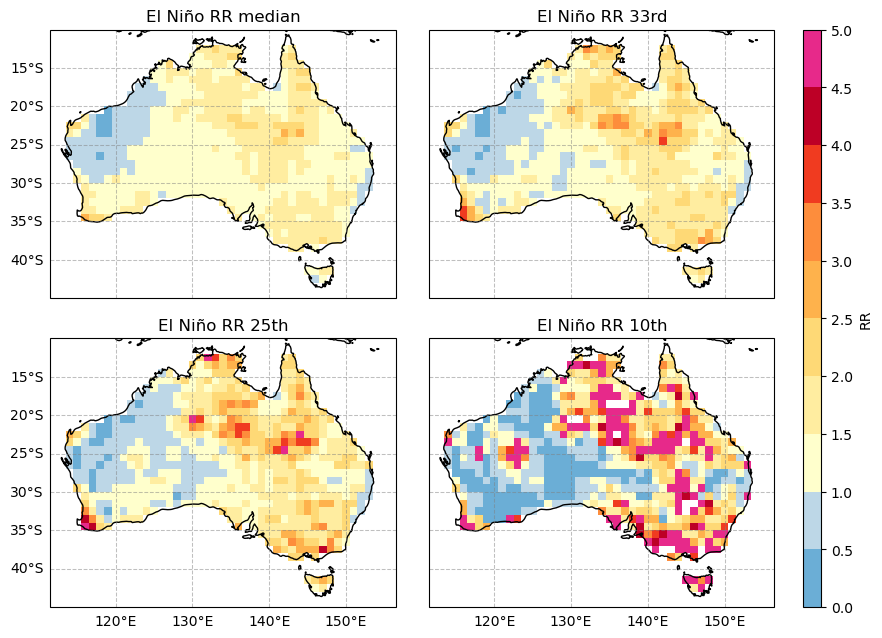

In [38]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = RR_EN_med_below.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño RR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = RR_EN_33th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño RR 33rd')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = RR_EN_25th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño RR 25th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = RR_EN_10th.plot(ax=ax, cmap=cmap_risk, norm=norm_risk, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('El Niño RR 10th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax, ticks=bounds_risk)
cbar.ax.set_ylabel('RR');

#### Continuous cbar

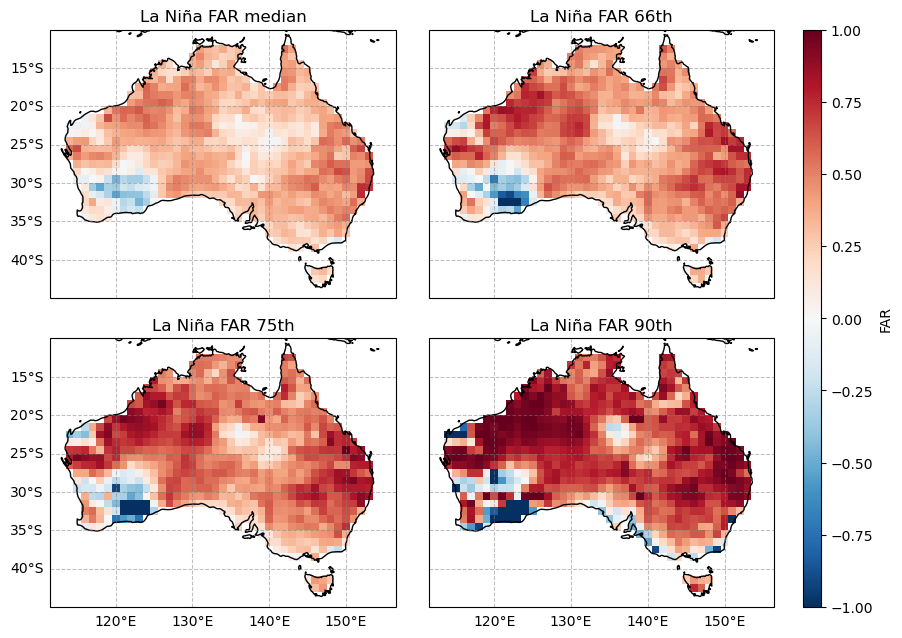

In [39]:
fig = plt.figure(figsize=(10, 7.5))  
gs = gridspec.GridSpec(2, 3, wspace=0.1, hspace=0.15, width_ratios=[1, 1, 0.05])

cmap = 'RdBu_r'
vmin = -1
vmax = 1

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
im = FAR_LN_med_above.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR median')
ax = format_gridlines(ax, left_labels=True) 

ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
im = FAR_LN_66th.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 66th')
ax = format_gridlines(ax)

ax = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
im = FAR_LN_75th.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 75th')
ax = format_gridlines(ax, left_labels=True, bottom_labels=True)

ax = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
im = FAR_LN_90th.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('La Niña FAR 90th')
ax = format_gridlines(ax, bottom_labels=True)

cax = plt.subplot(gs[:, 2])
cbar = plt.colorbar(im, cax)
cbar.ax.set_ylabel('FAR');